In [149]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.3
⌃ [780c37f4] Carlo v0.2.4
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [150]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using LinearAlgebra

In [151]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :K, :Lx, :Ly, :Mag, :Energy, :Dxπ, :Dyπ, :P],
)

cleandata (generic function with 1 method)

In [165]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false, label="")
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals; label)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false)
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [153]:
jobname = "temp-sweep"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,40,40,0.001456±4.4e-5,-1.995±2.4e-5,0.98856±0.00024,0.98855±0.00024,0.0361±0.004
2,0.05,-0.005,40,40,0.003437±5.7e-5,-1.9545±0.00011,0.9388±0.002,0.9388±0.002,0.094±0.014
3,0.1,-0.005,40,40,0.004936±7.1e-5,-1.90369±0.00011,0.8846±0.0018,0.8846±0.0018,0.0834±0.0061
4,0.125,-0.005,40,40,0.005367±7.3e-5,-1.87772±0.00017,0.852±0.0039,0.8519±0.0039,0.118±0.013
5,0.15,-0.005,40,40,0.006005±4.8e-5,-1.85191±0.00017,0.8255±0.0018,0.8255±0.0018,0.0935±0.0062
6,0.175,-0.005,40,40,0.006458±4.5e-5,-1.82542±0.00018,0.7867±0.0053,0.7866±0.0052,0.139±0.015
7,0.2,-0.005,40,40,0.006921±4.4e-5,-1.79934±0.0002,0.7631±0.0031,0.7631±0.003,0.1268±0.0092
8,0.225,-0.005,40,40,0.007414±6.0e-5,-1.77229±0.00023,0.7144±0.0093,0.7143±0.0093,0.155±0.018
9,0.25,-0.005,40,40,0.007949±6.1e-5,-1.74497±0.00022,0.6873±0.0062,0.6872±0.0062,0.119±0.019


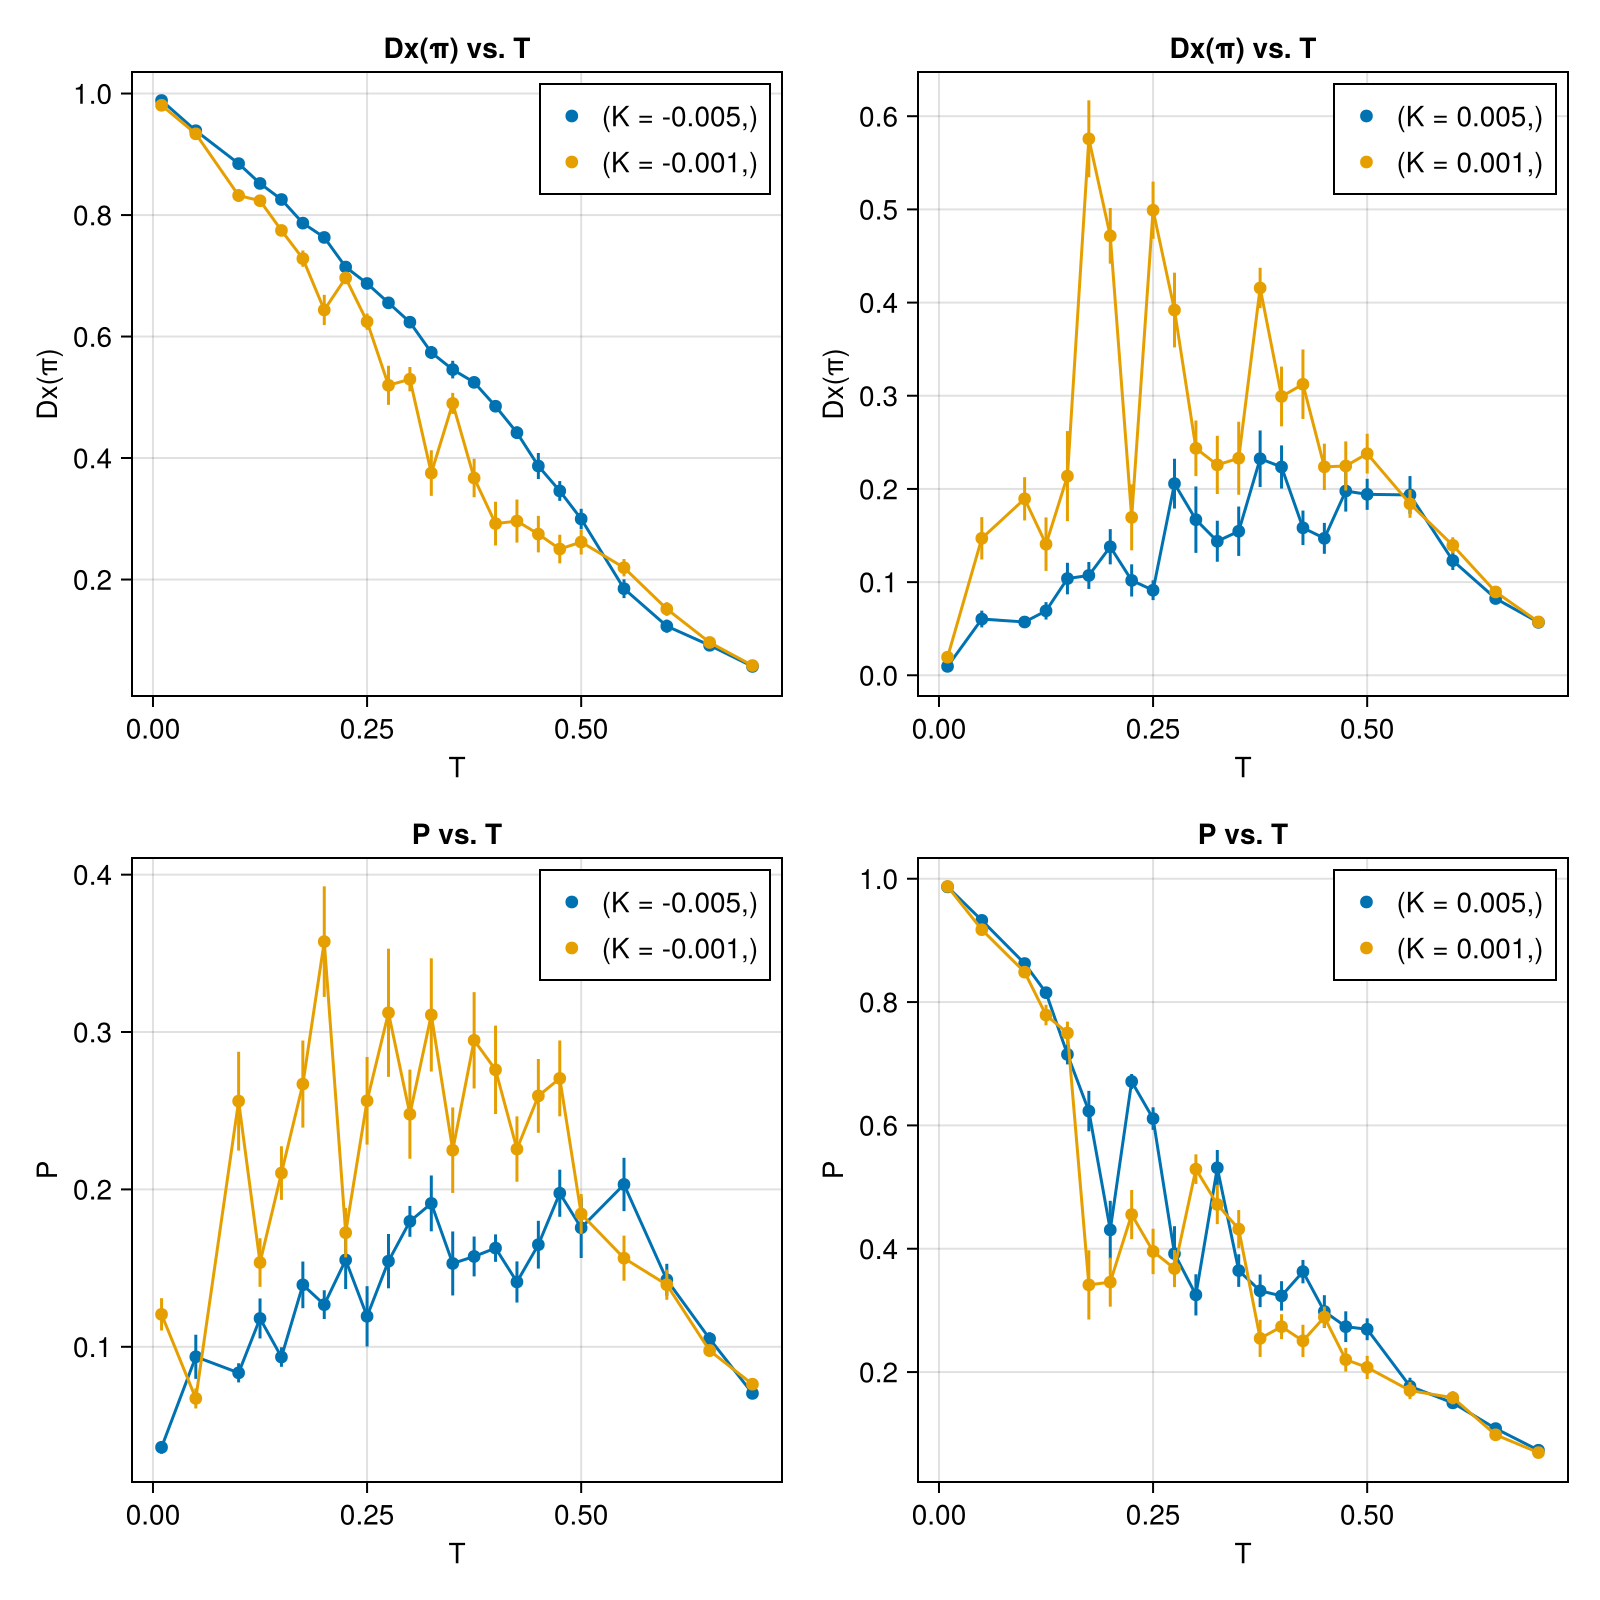

In [176]:
fig = Figure(size=(800, 800))

generatePlot(
    data[[1, 3]], :T, :Dxπ; fig,
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)",
    line=true
)
generatePlot(
    data[[2, 4]], :T, :Dxπ; fig, fig_pos=(1,2),
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)",
    line=true
)

generatePlot(
    data[[1, 3]], :T, :P; fig, fig_pos=(2,1),
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)
generatePlot(
    data[[2, 4]], :T, :P; fig, fig_pos=(2,2),
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)

In [156]:
ungrouped_data = cleandata("../jobs/$jobname.results.json")

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,40,40,0.001456±4.4e-5,-1.995±2.4e-5,0.98856±0.00024,0.98855±0.00024,0.0361±0.004
2,0.05,-0.005,40,40,0.003437±5.7e-5,-1.9545±0.00011,0.9388±0.002,0.9388±0.002,0.094±0.014
3,0.1,-0.005,40,40,0.004936±7.1e-5,-1.90369±0.00011,0.8846±0.0018,0.8846±0.0018,0.0834±0.0061
4,0.125,-0.005,40,40,0.005367±7.3e-5,-1.87772±0.00017,0.852±0.0039,0.8519±0.0039,0.118±0.013
5,0.15,-0.005,40,40,0.006005±4.8e-5,-1.85191±0.00017,0.8255±0.0018,0.8255±0.0018,0.0935±0.0062
6,0.175,-0.005,40,40,0.006458±4.5e-5,-1.82542±0.00018,0.7867±0.0053,0.7866±0.0052,0.139±0.015
7,0.2,-0.005,40,40,0.006921±4.4e-5,-1.79934±0.0002,0.7631±0.0031,0.7631±0.003,0.1268±0.0092
8,0.225,-0.005,40,40,0.007414±6.0e-5,-1.77229±0.00023,0.7144±0.0093,0.7143±0.0093,0.155±0.018
9,0.25,-0.005,40,40,0.007949±6.1e-5,-1.74497±0.00022,0.6873±0.0062,0.6872±0.0062,0.119±0.019


In [157]:
function generate_mctime_plot(task_no::Int)
    fig = Figure(size=(800, 400))

    ax_P = fig[1,1] = Axis(
        fig,
        title="P vs. Bin #",
        xlabel="Bin #",
        ylabel="P",
        xminorticksvisible=true
    )
    ax_Dxπ = fig[1,2] = Axis(
        fig,
        title="Dx(π) vs. Bin #",
        xlabel="Bin #",
        ylabel="Dx(π)",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]
        P_samples = read(observables, "P/samples")
        n = length(P_samples)
        init = 1
        lines!(
            ax_P,
            collect(init:n),
            P_samples[init:n],
        )
        Dxπ_samples = read(observables, "Dxπ/samples")
        lines!(
            ax_Dxπ,
            collect(init:n),
            Dxπ_samples[init:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 1 method)

DataFrameRow
 Row │ T        K        Lx     Ly     Mag              Energy            Dxπ         Dyπ         P           
     │ Float64  Float64  Int64  Int64  Measurem…        Measurem…         Measurem…   Measurem…   Measurem…   
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────
  56 │   0.275   -0.001     40     40  0.008402±4.8e-5  -1.71433±0.00038  0.52±0.032  0.52±0.032  0.312±0.041

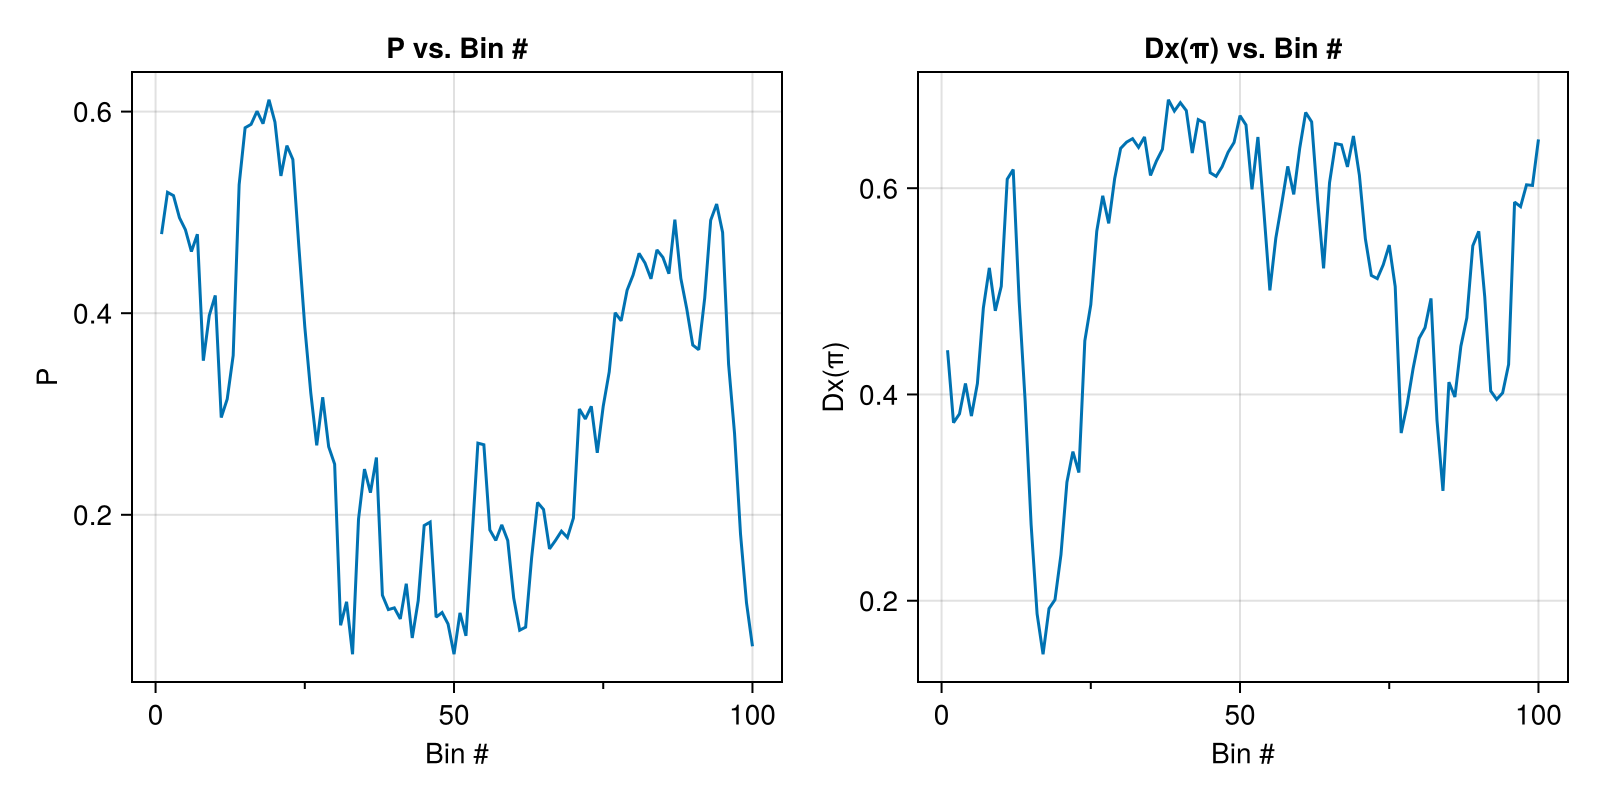

In [178]:
i = 56
print(ungrouped_data[i, :])
generate_mctime_plot(i)

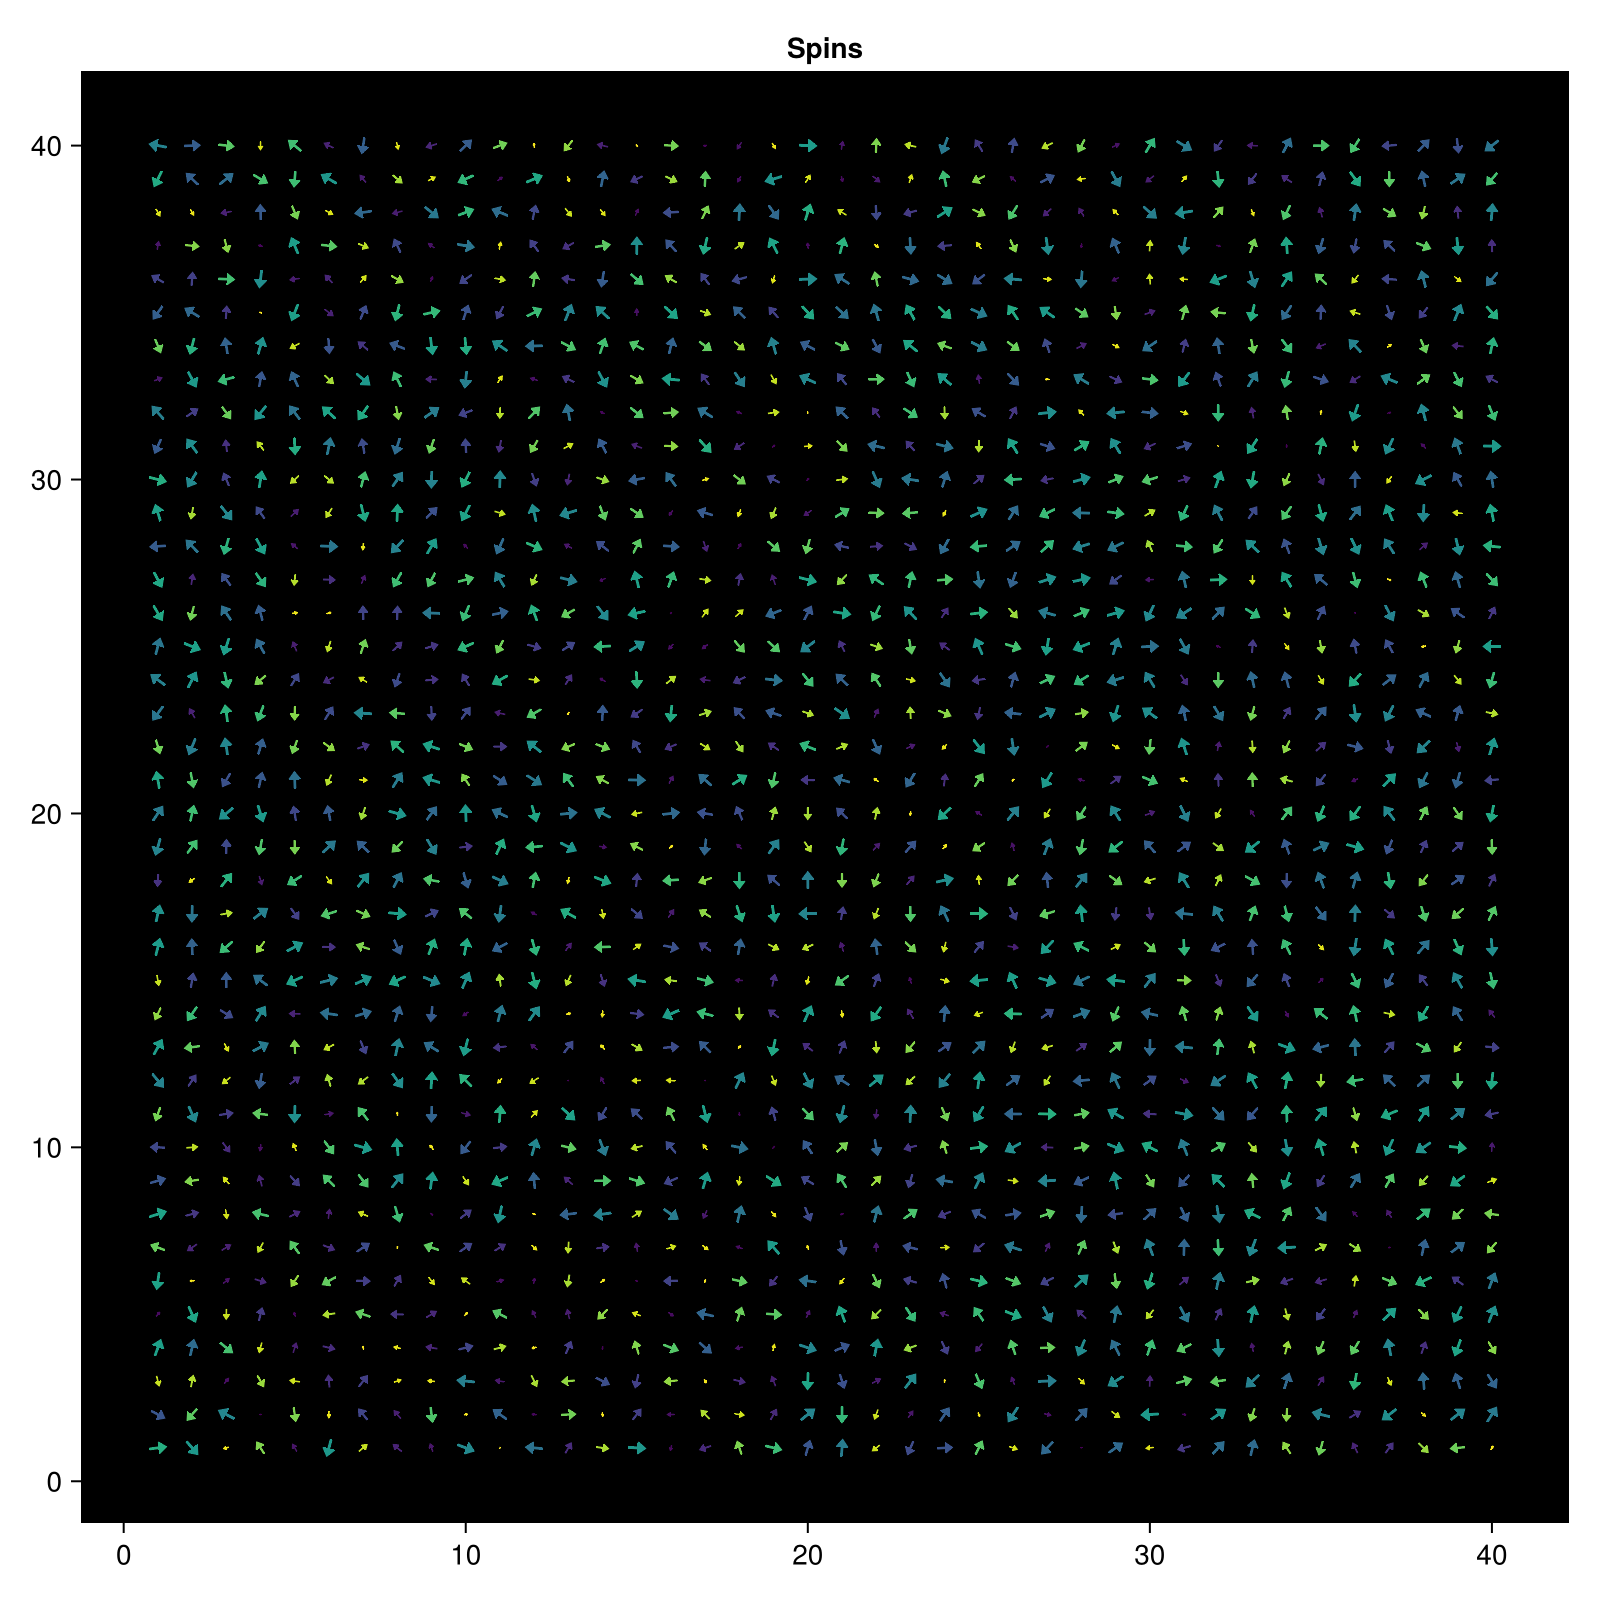

In [159]:
task_no = "21"
file = h5open("../jobs/$jobname.data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

fig = Figure(size=(800, 800))
fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig